In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time
import sys

sys.path.append(os.path.abspath(".."))   # Add root path to sys.path
os.chdir("..")  # Change working directory to root path

from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm
from datetime import datetime

sys.path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



['/opt/anaconda3/envs/cv_env/lib/python312.zip',
 '/opt/anaconda3/envs/cv_env/lib/python3.12',
 '/opt/anaconda3/envs/cv_env/lib/python3.12/lib-dynload',
 '',
 '/opt/anaconda3/envs/cv_env/lib/python3.12/site-packages',
 '/Users/tranquochieu/Documents/NCKH/Weather forecasting/code (new - 251)']

### Load data first

In [2]:
from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
from tqdm import tqdm

data_name = "KARX"
SOURCE_PATH = f"data/numpy_grid/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
]

img_shape = read_numpy_grid(img_paths[0]).shape       # get shape of the image

print(f"Image shape: {img_shape}")
print(f"-" * 20)

time_frames = []
dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]
    # time_frames.append(datetime.strptime(file_name[:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
    time_frames.append(datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S"))       # Get file name without extension
    img = read_numpy_grid(path)
    dbz_maps.append(nexrad_numpy_preprocessing_pipeline(img))

FIRST_TIME_FRAME = time_frames[0]

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (901, 901)
--------------------


Processing images and detecting storms: 100%|██████████| 93/93 [00:00<00:00, 242.41it/s]

Number of frames: 93


In [3]:
# file_name = "philippines_13.269_123.832"

# SOURCE_PATH = f"data/image_old/{file_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
# ][:50]

# img_shape = read_image(img_paths[0]).shape       # get shape of the image
# print(f"Image shape: {img_shape}")
# print(f"-" * 20)

# time_frames = []
# dbz_maps = []       

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     time_frames.append(datetime.strptime(os.path.basename(path).split('/')[0][:-4], '%Y%m%d-%H%M%S'))       # Get file name without extension
#     img = read_image(path)
#     dbz_maps.append(windy_preprocessing_pipeline(img))

# print(f"Number of frames: {len(dbz_maps)}")

In [4]:
# replace nan values with 0
for i in range(len(dbz_maps)):
    dbz_maps[i] = np.nan_to_num(dbz_maps[i], nan=0.0)

(dbz_maps[0] > 0).sum()

np.int64(86692)

## Load model

In [5]:
# import numpy as np
# import cv2
# from sklearn.cluster import KMeans
# from shapely.geometry import Polygon

# from src.cores.base import StormObject
# from src.preprocessing import convert_polygons_to_contours

# class ParticleStorm(StormObject):
#     particles: list[np.ndarray]  # list of (y,x) coordinates representing particles

#     def __init__(
#             self, contour: Polygon, history_movements = [], centroid = None, 
#             id = "", density: float = 0.05, shape: np.ndarray = None):
#         super().__init__(contour, history_movements, centroid, id)
#         self._sample_particles(density, shape)
    
#     def _sample_particles(self, density: float, shape: np.ndarray) -> None:
#         """
#         Sample particles within the storm contour.

#         Args:
#             density (float): Density of particles to sample.
#             shape (np.ndarray): Shape of the image containing the storm.
#         """
#         contour = convert_polygons_to_contours([self.contour])[0]
#         # get the set of points bounded by the contour
#         mask = np.zeros(shape=shape[:2], dtype=np.uint8)
#         cv2.fillPoly(mask, [contour], color=1)
#         points = np.argwhere(mask > 0)

#         # uniformly sample points using k-means.
#         num_particles = int(cv2.contourArea(contour) * density) + 1
#         k_means = KMeans(n_clusters=num_particles)
#         k_means.fit(points)

#         # particles: list of (y, x)
#         self.particles = k_means.cluster_centers_.astype(np.int64)

#     def make_move(self, movement):
#         super().make_move(movement)
#         # update particles
#         dy, dx = movement
#         for i in range(len(self.particles)):
#             self.particles[i][0] += dy
#             self.particles[i][1] += dx
    
#     def forecast_particles(self, grid_y, grid_x, vy, vx) -> np.ndarray:
#         """
#         Forecast the positions of particles based on the movement field. 
#         Idea: for each particle, retrieve its nearest movement vector and update its position accordingly.
#         """
#         forecasted_particles = self.particles.copy()
#         for i in range(len(forecasted_particles)):
#             y, x = forecasted_particles[i]
#             # get movement vector
#             grid_y_idx = np.clip(np.searchsorted(grid_y, y) - 1, 0, len(grid_y)-2)
#             grid_x_idx = np.clip(np.searchsorted(grid_x, x) - 1, 0, len(grid_x)-2)
#             dy = vy[grid_y_idx, grid_x_idx]
#             dx = vx[grid_y_idx, grid_x_idx]
#             # update particle position
#             forecasted_particles[i][0] += dy
#             forecasted_particles[i][1] += dx
        
#         return forecasted_particles
    
#     def get_num_particles(self):
#         """
#         Get the number of particles.
#         """
#         return len(self.particles)
    
#     def count_particles_in_storm(self, particles: np.ndarray, img_shape: list) -> int:
#         """
#         Count the number of particles inside the given contour.
#         """
#         mask = np.zeros(shape=img_shape[:2], dtype=np.uint8)
#         cv2.fillPoly(mask, convert_polygons_to_contours([self.contour]), color=1)

#         y_points = particles[:, 0]
#         x_points = particles[:, 1]

#         particle_mask = np.zeros(shape=img_shape[:2], dtype=np.uint8)
#         particle_mask[y_points, x_points] = 1

#         return np.sum(mask * particle_mask)


In [6]:
# import numpy as np
# from dataclasses import dataclass

# from src.tracking import BaseMatcher, reduced_soft_hungarian
# from src.cores.base import StormsMap

# from src.models.base.tracker import MatchedStormPair, UpdateType

# @dataclass
# class CellSubset:
#     """
#     Keep track of assigned storms cluster.
#     """
#     prev_indices: set[int]
#     curr_indices: set[int]

#     def add_cell(self, prev_idx: int = None, curr_idx: int = None):
#         """
#         add a source/target storm index to the subcell.
#         """
#         if prev_idx is not None:
#             self.prev_indices.add(prev_idx)
#         if curr_idx is not None:
#             self.curr_indices.add(curr_idx)

#     def merge_subcell(self, other: "CellSubset"):
#         """
#         merge another subcell into this one.
#         """
#         self.prev_indices = self.prev_indices.union(other.prev_indices)
#         self.curr_indices = self.curr_indices.union(other.curr_indices)

#     def contains(self, storm_order: int, is_source: bool=True) -> bool:
#         """
#         check if the cell contains the given source/target storm index.
#         """
#         return (storm_order in self.prev_indices) if is_source else (storm_order in self.curr_indices)

# class SubsetResolver:
#     matching_threshold: float

#     def __init__(self, matching_threshold: float):
#         self.matching_threshold = matching_threshold

#     def create_subsets(self, assignments: list[tuple[int, int]]) -> list[CellSubset]:
#         """
#         create subsets of storms based on the assignments between 2 time frames.
#         """
#         subcells: list[CellSubset] = []

#         for prev_idx, curr_idx in assignments:
#             prev_subcell = None
#             curr_subcell = None

#             # find if there is existing subcell containing prev_idx or curr_idx
#             for subcell in subcells:
#                 if subcell.contains(prev_idx, is_source=True):
#                     prev_subcell = subcell
#                 if subcell.contains(curr_idx, is_source=False):
#                     curr_subcell = subcell
            
#             # case 1: both are not belonged to any subcell => create new subcell
#             if not prev_subcell and not curr_subcell:
#                 # create new subcell
#                 new_subcell = CellSubset(prev_indices={prev_idx}, curr_indices={curr_idx})
#                 subcells.append(new_subcell)
#                 continue
                
#             # case 2: only one of them is belonged to a subcell => add the other index to that subcell
#             if prev_subcell and not curr_subcell:
#                 prev_subcell.add_cell(curr_idx=curr_idx)
#                 continue
#             if not prev_subcell and curr_subcell:
#                 curr_subcell.add_cell(prev_idx=prev_idx)
#                 continue
                
#             # case 3: both are belonged to different subcells => merge the 2 subcells
#             if prev_subcell != curr_subcell:
#                 prev_subcell.merge_subcell(curr_subcell)
#                 subcells.remove(curr_subcell)
        
#         return subcells

#     def resolve_subset(
#             self, subset: CellSubset, 
#             storms_map_lst_1: StormsMap, storms_map_lst_2: StormsMap, estimated_vectors: np.ndarray,
#             max_velocity: float, weights: list[float] = [0.5, 0.5]
#         ) -> list[MatchedStormPair]:
#         """
#         resolve the subset to get final assignments between 2 time frames.
#         """
#         # compute maximum displacement
#         dt = (storms_map_lst_1.time_frame - storms_map_lst_2.time_frame).total_seconds() / 3600.0
#         maximum_displacement = max_velocity * dt
#         particles_matcher = ParticleMatcher()

#         prev_storms_lst: list[tuple[int, ParticleStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_1.storms) \
#                                                             if idx in subset.prev_indices]
#         curr_storms_lst: list[tuple[int, ParticleStorm]] = [(idx, storm) for idx, storm in enumerate(storms_map_lst_2.storms) \
#                                                             if idx in subset.curr_indices]

#         particles_prev: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in prev_storms_lst for particle in storm.particles]
#         particles_curr: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in curr_storms_lst for particle in storm.particles]

#         # match particles
#         particle_assignments = particles_matcher.match_particles(
#             particles_prev, particles_curr, estimated_vectors, maximum_displacement, weights
#         )

#         # count number of matched particles between each pair of storms
#         matching_count = np.zeros(
#             (len(storms_map_lst_1.storms), len(storms_map_lst_2.storms)), dtype=np.int64
#         )

#         for idx1, idx2 in particle_assignments:
#             matching_count[particles_prev[idx1].storm_order, particles_curr[idx2].storm_order] += 1
        
#         # compute probability matrix
#         ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
#         ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
#         p_A = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_1.storms])[:, np.newaxis]
#         p_B = matching_count / np.array([len(storm.particles) for storm in storms_map_lst_2.storms])[np.newaxis, :]

#         # print(f"Matching count:\n{matching_count}")

#         p = np.max([p_A, p_B], axis=0)
#         assignments = np.argwhere(p >= self.matching_threshold)

#         new_subsets = self.create_subsets(assignments)

#         # print(f"Subset: {subset}")
#         # print(f"New subsets: {new_subsets}")

#         final_assignments: list[MatchedStormPair] = []
#         assigned_prev = set()
#         assigned_curr = set()

#         for new_subset in new_subsets:
#             prev_correspondence = {prev_idx: [] for prev_idx in new_subset.prev_indices}
#             curr_correspondence = {curr_idx: [] for curr_idx in new_subset.curr_indices}

#             for prev_idx, curr_idx in assignments:
#                 if prev_idx in new_subset.prev_indices and curr_idx in new_subset.curr_indices:
#                     prev_correspondence[prev_idx].append(curr_idx)
#                     curr_correspondence[curr_idx].append(prev_idx)

#             ## 1. split
#             for prev_idx in prev_correspondence.keys():
#                 # highest p_A => inherit parent
#                 prev_correspondence[prev_idx] = sorted(
#                     prev_correspondence[prev_idx], key=lambda x: p_A[prev_idx, x], reverse=True
#                 )
            
#             ## 2. merge
#             for curr_idx in curr_correspondence.keys():
#                 # highest p_B => inherit parent
#                 curr_correspondence[curr_idx] = sorted(
#                     curr_correspondence[curr_idx], key=lambda x: p_B[x, curr_idx], reverse=True
#                 )

#             # Determine velocity = weighted average displacement
#             def _get_weighted_centroid(storms: list[ParticleStorm]) -> np.ndarray:
#                 """
#                 Get the centroids of the list of storms.

#                 Args:
#                     storms (list[ParticleStorm]): the list of storms.

#                 Returns:
#                     centroids (np.ndarray): the array of centroids.
#                 """
#                 centroids = np.array([storm.centroid for storm in storms])
#                 areas = np.array([storm.contour.area for storm in storms])
#                 weights = areas / np.sum(areas)

#                 return np.average(centroids, weights=weights, axis=0)
        
#             prev_mean_centroid = _get_weighted_centroid(
#                 [storms_map_lst_1.storms[idx] for idx in new_subset.prev_indices]
#             )   # (y, x)
#             curr_mean_centroid = _get_weighted_centroid(
#                 [storms_map_lst_2.storms[idx] for idx in new_subset.curr_indices]
#             )   # (y, x)
#             displacement = curr_mean_centroid - prev_mean_centroid   # (dy, dx)
            
#             for curr_idx, prev_indices in curr_correspondence.items():
#                 if len(prev_indices) == 0:
#                     final_assignments.append(
#                         MatchedStormPair(
#                             prev_storm_order=None,
#                             curr_storm_order=curr_idx,
#                             update_type=UpdateType.NEW,
#                             estimated_movement=np.array([0.0, 0.0])
#                         )
#                     )
#                     assigned_curr.add(curr_idx)
#                     continue

#                 prev_idx = prev_indices[0]
#                 if prev_idx in assigned_prev:   # case split
#                     final_assignments.append(
#                         MatchedStormPair(
#                             prev_storm_order=prev_idx,
#                             curr_storm_order=curr_idx,
#                             update_type=UpdateType.SPLITTED,
#                             estimated_movement=displacement
#                         )
#                     )
#                     assigned_curr.add(curr_idx)
#                 else:
#                     final_assignments.append(
#                         MatchedStormPair(
#                             prev_storm_order=prev_idx,
#                             curr_storm_order=curr_idx,
#                             update_type=UpdateType.MATCHED,
#                             estimated_movement=displacement
#                         )
#                     )
#                     assigned_prev.add(prev_idx)
#                     assigned_curr.add(curr_idx)
                
#             for prev_idx, curr_indices in prev_correspondence.items():
#                 if prev_idx in assigned_prev or len(curr_indices) == 0:
#                     continue

#                 curr_idx = curr_indices[0]
#                 if curr_idx in assigned_curr:   # case merge
#                     final_assignments.append(
#                         MatchedStormPair(
#                             prev_storm_order=prev_idx,
#                             curr_storm_order=curr_idx,
#                             update_type=UpdateType.MERGED,
#                             estimated_movement=displacement
#                         )
#                     )
#                     assigned_prev.add(prev_idx)
#                 else:
#                     final_assignments.append(
#                         MatchedStormPair(
#                             prev_storm_order=prev_idx,
#                             curr_storm_order=curr_idx,
#                             update_type=UpdateType.MATCHED,
#                             estimated_movement=displacement
#                         )
#                     )
#                     assigned_prev.add(prev_idx)
#                     assigned_curr.add(curr_idx)
            
#             # print(f"+ Curr correspondence: {curr_correspondence}")
#             # print(f"+ Prev correspondence: {prev_correspondence}")
#             # print(f"- Final assignments so far: {final_assignments}")

#         for curr_idx in subset.curr_indices:
#             if curr_idx not in assigned_curr:
#                 final_assignments.append(
#                     MatchedStormPair(
#                         prev_storm_order=None,
#                         curr_storm_order=curr_idx,
#                         update_type=UpdateType.NEW,
#                         estimated_movement=np.array([0.0, 0.0])
#                     )
#                 )

#         # print(f"- Final assignments after adding new storms: {final_assignments}")
#         return final_assignments

In [7]:
# import numpy as np

# from dataclasses import dataclass

# from src.tracking import BaseMatcher

# @dataclass
# class Particle:
#     position: np.ndarray
#     storm_order: int        # order of the storm this particle belongs to

# class ParticleMatcher(BaseMatcher):
#     def _construct_disparity_matrix(
#             self, particle_lst1: list[Particle], particle_lst2: list[Particle], estimated_vectors: np.ndarray, 
#             weights: list[float], max_displacement: float
#         ):
#         """
#         Construct a disparity matrix for 2 lists of particles.

#         Parameters:
#             particle_lst1 (list[Particle]): The first list of particles.
#             particle_lst2 (list[Particle]): The second list of particles.
#             estimated_vectors (np.ndarray): The estimated movement vectors for each particle in `particle_lst1`.
#             weights (list[float]): the list of nonnegative- and sum-to-1 weights.

#         Returns:
#             cost_matrix, T_D, T_S (tuple[np.ndarray, np.ndarray]): The constructed disparity matrix and distance matrix for later verification.
#         """
#         assert all([all([w >= 0 for w in weights]), np.sum(weights) == 1]), "weights must not be negative and must sum to 1."
#         n2 = len(particle_lst2)
#         coord_1 = np.array([p.position for p in particle_lst1])
#         coord_2 = np.array([p.position for p in particle_lst2])

#         displacement_matrix = -(coord_1[:, np.newaxis, :] - coord_2[np.newaxis, :, :])         # shape: (n1, n2, 2)
#         estimated_matrix = np.repeat(estimated_vectors[:, np.newaxis, :], n2, axis=1)       # shape: (n1, n2, 2)

#         # compute T_D
#         dot_product = np.sum(displacement_matrix * estimated_matrix, axis=-1)  # (n1, n2)
#         norms = (np.linalg.norm(displacement_matrix, axis=-1) *
#                     np.linalg.norm(estimated_matrix, axis=-1) + 1e-8)
#         T_D = 1 - dot_product / norms   # shape: (n1, n2)
        
#         # compute T_S
#         norm_displ_matrix = np.linalg.norm(displacement_matrix - estimated_matrix, axis=-1)       # shape: (n1, n2)
#         max_diff_matrix = np.clip(max_displacement - norm_displ_matrix, a_min=0, a_max=max_displacement)
#         T_S = 1 - (2 * np.sqrt(max_displacement * max_diff_matrix)) / (max_displacement + max_diff_matrix + 1e-6)   # shape: (n1, n2)

#         # compute cost matrix
#         cost_matrix = weights[0] * T_D + weights[1] * T_S

#         return cost_matrix, T_D, T_S
    
#     def match_particles(
#             self, particle_lst1: list[Particle], particle_lst2: list[Particle], estimated_vectors: np.ndarray, 
#             maximum_displacement: float, weights: list[float] = [0.5, 0.5]
#         ) -> np.ndarray:
#         """
#         Match particles between 2 lists of particles.
#         Parameters:
#             particle_lst1 (list[Particle]): The first list of particles.
#             particle_lst2 (list[Particle]): The second list of particles.
#             maximum_displacement (float): The maximum displacement allowed for a particle to be considered a match.
#             weights (list[float], default=[0.5, 0.5]): the list of nonnegative- and sum-to-1 weights.
#         Returns:
#             assignments (np.ndarray): The array of matched indices between the 2 lists of particles.
#         """
#         # print(f"ParticleMatcher weights: {weights}")
#         cost_matrix, T_D, T_S = self._construct_disparity_matrix(
#             particle_lst1, particle_lst2, estimated_vectors=estimated_vectors, 
#             max_displacement=maximum_displacement, weights=weights
#         )
#         invalid_mask = (T_D >= 1) & (T_S >= 1)
        
#         row_ind, col_ind = self._hungarian_matching(cost_matrix)
#         assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
#         assignment_mask[row_ind, col_ind] = True

#         return np.argwhere(assignment_mask & np.logical_not(invalid_mask))

In [8]:
# import numpy as np

# from src.cores.movement_estimate import TREC
# from src.cores.base import StormsMap, StormObject
# from src.tracking import reduced_soft_hungarian

# from src.models.base.tracker import MatchedStormPair, UpdateType

# class STitanMatcher:
#     trec: TREC

#     def __init__(
#             self, max_velocity: float, trec: TREC, weights: tuple[float, float], matching_threshold: float = 0.5
#         ):
#         self.max_velocity = max_velocity
#         self.trec = trec
#         self.weights = weights
#         self.particles_matcher = ParticleMatcher()
#         self.subset_resolver = SubsetResolver(matching_threshold)
    
#     def match_storms(
#             self, storms_map_1: StormsMap, storms_map_2: StormsMap, 
#             first_guess: bool = False     # for TREC overlapping matching
#         ) -> list[MatchedStormPair]:
#         """
#         Match storms between 2 time frame.

#         Args:
#             storms_map_1 (StormsMap): storm map in the 1st frame.
#             storms_map_2 (StormsMap): storm map in the 2nd frame.
        
#         Returns:
#             assignments (list[MatchedStormPair]): Array of (prev_idx, curr_idx) pairs representing matched storms.
#         """
#         # get particles lists for both time frames
#         particles_prev: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in enumerate(storms_map_1.storms) for particle in storm.particles]
#         particles_curr: list[Particle] = [Particle(position=particle, storm_order=idx) for idx, storm in enumerate(storms_map_2.storms) for particle in storm.particles]

#         # compute maximum displacement
#         dt = (storms_map_2.time_frame - storms_map_1.time_frame).total_seconds() / 3600.0
#         maximum_displacement = self.max_velocity * dt

#         # estimate movement vectors for storms in the previous frame
#         ## 1. Case first_guess = True: use TREC to estimate movement field
#         estimated_particles_vectors = []
#         estimated_storms_vectors = []

#         if first_guess:
#             grid_y, grid_x, vy, vx = self.trec.estimate_movement(storms_map_1, storms_map_2)
#             for prev_storm in storms_map_1.storms:
#                 storm_vector = self.trec.average_storm_movement(
#                     prev_storm, storms_map_1.dbz_map.shape[:2],
#                     grid_y, grid_x, vy, vx
#                 )
#                 estimated_particles_vectors.extend([storm_vector] * len(prev_storm.particles))
#                 estimated_storms_vectors.append(storm_vector)
            
#         ## 2. Case first_guess = False: use previous displacement to estimate movement vectors
#         else:
#             for prev_storm in storms_map_1.storms:
#                 movement = prev_storm.get_movement()
#                 if movement is None:
#                     movement = np.array([0.0, 0.0])
#                 else:
#                     movement = movement * dt
#                 estimated_particles_vectors.extend([movement] * len(prev_storm.particles))    # in (dy, dx) order, unit: pixels
#                 estimated_storms_vectors.append(movement)
        
#         estimated_particles_vectors = np.array(estimated_particles_vectors)    # shape: (num_prev_storms, 2)

#         # match particles
#         particle_assignments = self.particles_matcher.match_particles(
#             particles_prev, particles_curr, estimated_particles_vectors, maximum_displacement, self.weights
#         )

#         # count number of matched particles between each pair of storms
#         matching_count = np.zeros((len(storms_map_1.storms), len(storms_map_2.storms)), dtype=np.int64)
#         for prev_particle_idx, curr_particle_idx in particle_assignments:
#             prev_storm_idx = particles_prev[prev_particle_idx].storm_order
#             curr_storm_idx = particles_curr[curr_particle_idx].storm_order
#             matching_count[prev_storm_idx, curr_storm_idx] += 1
        
#         # compute probability matrix
#         ## p_A: Probability of matching where the denominator is the number of particles in the previous storm
#         ## p_B: Probability of matching where the denominator is the number of particles in the curr storm
#         p_A = matching_count / np.array([len(storm.particles) for storm in storms_map_1.storms])[:, np.newaxis]
#         p_B = matching_count / np.array([len(storm.particles) for storm in storms_map_2.storms])[np.newaxis, :]

#         # find the soft-hungarian assignment
#         assignments_A = reduced_soft_hungarian(1 - p_A)
#         assignments_B = reduced_soft_hungarian(1 - p_B)
#         ## temporary version
#         temp_assignments = list(set(assignments_A).union(set(assignments_B)))

#         ## justified version
#         subsets = self.subset_resolver.create_subsets(temp_assignments)
#         final_assignments: list[MatchedStormPair] = []
#         for subset in subsets:
#             estimated_particles_vectors = []
#             for prev_idx in subset.prev_indices:
#                 prev_storm = storms_map_1.storms[prev_idx]
#                 estimated_particles_vectors.extend([estimated_storms_vectors[prev_idx]] * len(prev_storm.particles))
            
#             estimated_particles_vectors = np.array(estimated_particles_vectors)    # shape: (num_prev_storms, 2)
#             final_assignments.extend(
#                 self.subset_resolver.resolve_subset(
#                     subset, storms_map_1, storms_map_2, estimated_particles_vectors,
#                     self.max_velocity, self.weights
#                 )
#             )

#         return final_assignments

In [9]:
# import cv2
# import numpy as np
# from datetime import datetime, timedelta

# from src.cores.base import StormObject, StormsMap
# from src.models.base.model import BasePrecipitationModel
# from src.identification import MorphContourIdentifier
# from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
# from src.cores.movement_estimate import BaseTREC, TREC

# from src.models.base.tracker import TrackingHistory, UpdateType

# DENSITY = 0.05  # particle density

# class ISCITPrecipitationModel(BasePrecipitationModel):
#     """
#     ISCIT model implementation for thunderstorm nowcasting.
#     """
#     identifier: MorphContourIdentifier
#     storms_maps: list[StormsMap]
#     tracker: TrackingHistory
#     matcher: STitanMatcher

#     def __init__(self, identifier: MorphContourIdentifier, trec: BaseTREC = None, 
#                  max_velocity: float = 100.0, weights: tuple[float, float] = (0.5, 0.5)):
#         self.identifier = identifier
#         self.storms_maps = []
#         if trec is None:
#             trec = TREC(max_velocity=max_velocity)

#         self.matcher = STitanMatcher(trec=trec, max_velocity=max_velocity, weights=weights)
#         self.tracker = None

#     def identify_storms(
#             self, dbz_map: np.ndarray, time_frame: datetime, map_id: str, threshold: float, filter_area: float, particle_density: float = DENSITY
#         ) -> StormsMap:
#         """
#         Identify storms in the given DBZ image at the specified timestamp.

#         Args:
#             dbz_img (np.ndarray): The DBZ image.
#             time_frame (datetime): The timestamp of the image.
#             map_id (str): The identifier for the storm map. Use for prefixing storm IDs.
#             threshold (float): The DBZ threshold for storm identification.
#             filter_area (float): The minimum area to filter storms.

#         Returns:
#             StormsMap: The identified storms map.
#         """
#         polygons = convert_contours_to_polygons(self.identifier.identify_storm(dbz_map=dbz_map, threshold=threshold, filter_area=filter_area))
#         polygons = sorted(polygons, key=lambda x: x.area, reverse=True)
#         storms = []

#         for idx, polygon in enumerate(polygons):
#             contour = convert_polygons_to_contours([polygon])[0]

#             # Create the mask of current storm
#             mask = np.zeros_like(dbz_map, dtype=np.uint8)
#             cv2.fillPoly(mask, contour, color=1)

#             # Extract DBZ values inside mask
#             weights = dbz_map * mask
#             y_idx, x_idx = np.indices(dbz_map.shape)
#             total_weight = weights.sum()

#             if total_weight == 0:
#                 centroid = (np.nan, np.nan)  # or fallback
#             else:
#                 cx = (x_idx * weights).sum() / total_weight
#                 cy = (y_idx * weights).sum() / total_weight
#                 centroid = (int(cy), int(cx))

#             storms.append(
#                 ParticleStorm(polygon, centroid=centroid, id=f"{map_id}_storm_{idx}", shape=dbz_map.shape[:2], density=particle_density)
#             )
            
#         return StormsMap(storms=storms, time_frame=time_frame, dbz_map=dbz_map)
    
#     def processing_map(self, curr_storms_map: StormsMap):
#         if len(self.storms_maps) == 0:
#             self.storms_maps.append(curr_storms_map)
#             self.tracker = TrackingHistory(curr_storms_map)
#         else:
#             prev_storms_map = self.storms_maps[-1]
#             dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour

#             # match using Hungarian algorithm
#             first_guess = len(self.storms_maps) == 1
#             matched: list[MatchedStormPair] = self.matcher.match_storms(
#                 prev_storms_map, curr_storms_map, first_guess=first_guess
#             )

#             for info in matched:
#                 if info.update_type == UpdateType.NEW:
#                     self.tracker.add_new_track(
#                         new_storm=curr_storms_map.storms[info.curr_storm_order],
#                         time_frame=curr_storms_map.time_frame
#                     )
#                 else:
#                     self.tracker.update_track(
#                         prev_storm=prev_storms_map.storms[info.prev_storm_order],
#                         curr_storm=curr_storms_map.storms[info.curr_storm_order],
#                         update_type=info.update_type,
#                         time_frame=curr_storms_map.time_frame,
#                         velocity=info.derive_motion_vector(dt=dt)
#                     )

#             self.storms_maps.append(curr_storms_map)

#     def forecast(self, lead_time: float) -> StormsMap:
#         """
#         Predict future storms up to lead_time based on the current storm map.

#         Args:
#             lead_time (float): The lead time in second for prediction.
#         """
#         dt = lead_time / 3600  # scaled to hour
#         current_map = self.storms_maps[-1]
#         new_storms = []
#         for storm in current_map.storms:
#             new_storms.append(storm.forecast(dt))
        
#         return StormsMap(storms=new_storms, time_frame=current_map.time_frame + timedelta(hours=dt), dbz_map=None)

In [10]:
from src.models import ISCITPrecipitationModel
from src.identification import HypothesisIdentifier
from src.cores.base import StormsMap

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())

storms_maps: list[StormsMap] = []
total_storms = 0
DENSITY = 0.1  # particle density

pbar = tqdm(zip(dbz_maps, time_frames), total=len(dbz_maps), desc="Detecting storms")
for idx, (dbz_map, time_frame) in enumerate(pbar):
    storms_map = model.identify_storms(
        dbz_map, time_frame, map_id=f"time_{idx}", threshold=35, filter_area=50, particle_density=DENSITY
    )
    total_storms += len(storms_map.storms)
    pbar.set_postfix({"Total storms detected": total_storms})

    storms_maps.append(storms_map)

Detecting storms: 100%|██████████| 93/93 [01:57<00:00,  1.26s/it, Total storms detected=2452]


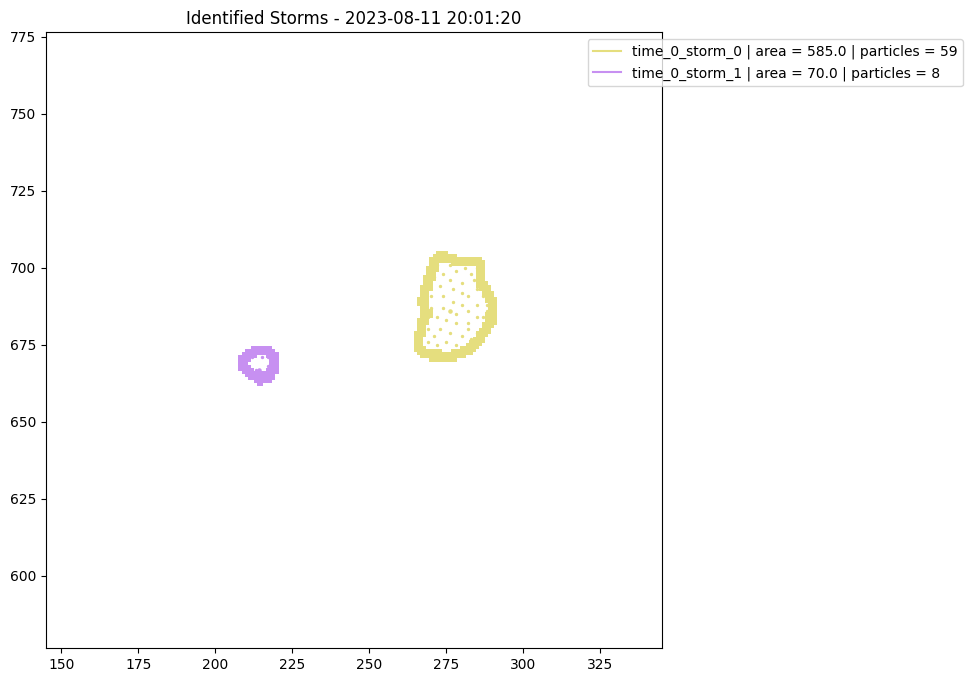

In [11]:
from src.preprocessing import convert_polygons_to_contours

# Visualize storms with contours on the first DBZ map
storms_map = storms_maps[0]
plt.figure(figsize=(10, 8))

img_shape = dbz_maps[0].shape
img_shape = (img_shape[0], img_shape[1], 3)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# colors = spectral_colors(len(storms_map.storms))
displayed_centroid_lst = []

for storm in storms_map.storms:
    y_centroid, x_centroid = storm.centroid
    displayed_centroid_lst.append([y_centroid, x_centroid])
    color = storm.contour_color
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f} | particles = {storm.get_num_particles()}")
    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=2)  # Draw contour in red
    for particle in storm.particles:
        y_particle, x_particle = particle
        plt.scatter(x_particle, y_particle, color=np.array(color)/255.0, s=2)

displayed_centroid = np.mean(np.array(displayed_centroid_lst), axis=0)

plt.imshow(blank_image, cmap='grey')
plt.title(f"Identified Storms - {storms_map.time_frame}")
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
plt.xlim(displayed_centroid[1] - 100, displayed_centroid[1] + 100)
plt.ylim(displayed_centroid[0] - 100, displayed_centroid[0] + 100)

plt.show()

Storm time_0_storm_0 estimated movement vector: (np.float64(-1.687797147358355), np.float64(4.421553090262733))
Storm time_0_storm_1 estimated movement vector: (np.float64(-0.4588235293577855), np.float64(4.670588234744637))
Track  0. time_0_storm_0 -> time_1_storm_0
Lifespan: 2
	time_0_storm_0: 
	time_1_storm_0: (-41.22, 82.44)
--------------------------------------------------
Track  1. time_0_storm_1 -> time_1_storm_2
Lifespan: 2
	time_0_storm_1: 
	time_1_storm_2: (0.00, 219.85)
--------------------------------------------------
Track  2. time_1_storm_1
Lifespan: 1
	time_1_storm_1: 
--------------------------------------------------


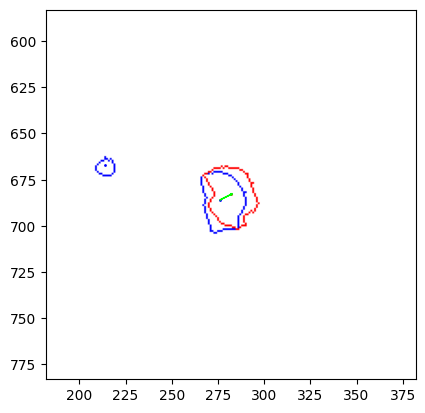

In [12]:
from src.cores.movement_estimate import TREC

prev_storm_map = storms_maps[0]
curr_storm_map = storms_maps[1]

trec = TREC(max_velocity=100.0)
grid_y, grid_x, vy, vx = trec.estimate_movement(prev_storm_map, curr_storm_map)

for idx, prev_storm in enumerate(prev_storm_map.storms):
    storm_vector = trec.average_storm_movement(
        prev_storm, prev_storm_map.dbz_map.shape[:2],
        grid_y, grid_x, vy, vx
    )
    print(f"Storm {prev_storm.id} estimated movement vector: {storm_vector}")

dt = (curr_storm_map.time_frame - prev_storm_map.time_frame).seconds / 3600   # scaled to hour

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())
model.processing_map(prev_storm_map)
model.processing_map(curr_storm_map)

model.tracker.print_tracks()

# plot the previous map
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in prev_storm_map.storms:
    y_centroid, x_centroid = storm.centroid
    
    plt.plot([], [], color=(0,0,1), label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_centroid, y_centroid, color=(0,0,1), s=1)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, (0,0,255), thickness=1)  # Draw contour in blue

# plot the current storm
curr_idx = 0
y_centroid, x_centroid = curr_storm_map.storms[curr_idx].centroid
movement = curr_storm_map.storms[curr_idx].get_movement()
if movement is None:
    dy, dx = 0.0, 0.0
else:
    dy, dx = movement * dt

plt.plot([], [], color=(1,0,0), label=f"{curr_storm_map.storms[curr_idx].id} | area = {curr_storm_map.storms[curr_idx].contour.area:.1f}")
plt.scatter(x_centroid, y_centroid, color=(1,0,0), s=1)
cv2.drawContours(blank_image, convert_polygons_to_contours([curr_storm_map.storms[curr_idx].contour]), -1, (255,0,0), thickness=1)  # Draw contour in red

plt.arrow(
    x_centroid - dx, y_centroid - dy,
    dx, dy,
    color=(0, 1, 0), head_width=1, head_length=1
)

plt.imshow(blank_image, cmap='grey')
plt.xlim(x_centroid - 100, x_centroid + 100)
plt.ylim(y_centroid + 100, y_centroid - 100)

plt.show()

In [19]:
from src.cores.base import StormsMap
from src.cores.metrics import pod_score, far_score, csi_score

class PredictionBenchmarkModel:
    def __init__(self):
        self.pods = []
        self.fars = []
        self.csis = []
        self.actual = []
        self.predicted = []

    def evaluate_predict(self, actual_storms_map: StormsMap, predicted_storms_map: StormsMap):
        self.actual.append(actual_storms_map)
        self.predicted.append(predicted_storms_map)
        self.pods.append(pod_score(actual_storms_map, predicted_storms_map))
        self.fars.append(far_score(actual_storms_map, predicted_storms_map))
        self.csis.append(csi_score(actual_storms_map, predicted_storms_map))

# Create benchmark model
benchmark_model = PredictionBenchmarkModel()
PREDICT_FORWARD_STEPS = 3
SLOW_START_STEPS = 10

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())  # max_velocity in pixels per hour
temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
predicted_maps = []
lead_times = []

for i in range(SLOW_START_STEPS):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

# model.tracker.print_tracks()

for curr_map, future_map in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], temp_storm_map[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt_seconds = (future_map.time_frame - model.storms_maps[-1].time_frame).total_seconds()
    predicted_map = model.forecast(dt_seconds)
    ours_model_evaluation.evaluate_predict(future_map, predicted_map)
    lead_times.append(dt_seconds)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("Our model evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")

print(f"\tAverage lead time: {np.mean(lead_times) / 60:.2f} minutes")

Predicting precipitation maps: 100%|██████████| 80/80 [00:20<00:00,  3.89it/s]

Our model evaluation:
	Average POD: 0.2634
	Average FAR: 0.7413
	Average CSI: 0.1520
	Average lead time: 23.85 minutes


# Overall Analyzing on tracking process
In this tracking, I used both of the median duration and linearity error of tracking

Average object consistency score (area change rate): 1.2997


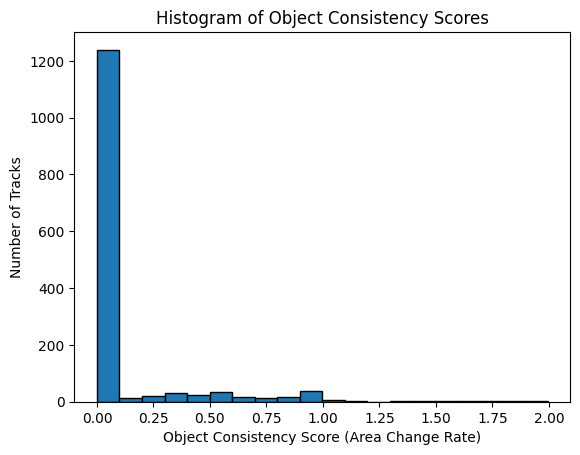

In [14]:
object_consistency_scores = []

for track in model.tracker.tracks:
    areas = [storm.contour.area for storm in track.storms.values()]
    area_changes = [abs(areas[i] - areas[i - 1]) / areas[i - 1] for i in range(1, len(areas)) if areas[i - 1] != 0]
    object_consistency_scores.append(np.mean(area_changes) if area_changes else 0)

object_consistency_scores = np.array(object_consistency_scores)

print(f"Average object consistency score (area change rate): {np.mean(object_consistency_scores):.4f}")

plt.hist(object_consistency_scores[object_consistency_scores < 2], bins=20, edgecolor='black')
plt.title("Histogram of Object Consistency Scores")
plt.xlabel("Object Consistency Score (Area Change Rate)")
plt.ylabel("Number of Tracks")
plt.show()

## B. Mean duration tracking

Median duration of tracking: 31.41231647634584 frames
Maximum duration of tracking: 89 frames
Mean duration of tracking: 31.41 frames


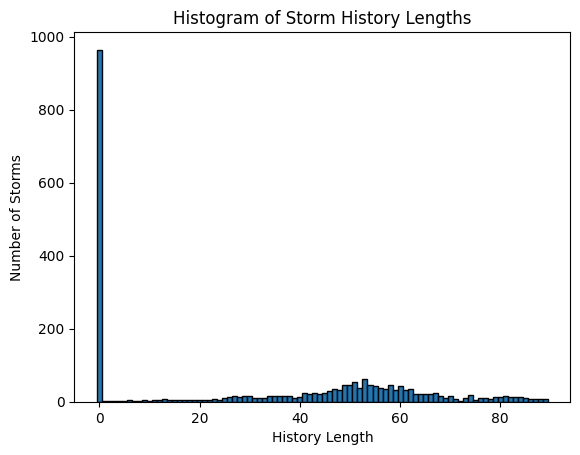

In [15]:
HISTORY_LENGTH_LST = []             # Retrieve history length of all storms

for storms_map in storms_maps:
    for storm in storms_map.storms:
        HISTORY_LENGTH_LST.append(len(storm.history_movements))   # Append history length of each storm

MEDIAN_DURATION = np.mean(HISTORY_LENGTH_LST)

print(f"Median duration of tracking: {MEDIAN_DURATION} frames")
print(f"Maximum duration of tracking: {max(HISTORY_LENGTH_LST)} frames")
print(f"Mean duration of tracking: {np.mean(HISTORY_LENGTH_LST):.2f} frames")

plt.hist(HISTORY_LENGTH_LST, bins=range(0, max(HISTORY_LENGTH_LST) + 2), align='left', edgecolor='black')
plt.title("Histogram of Storm History Lengths")
plt.xlabel("History Length")
plt.ylabel("Number of Storms")
plt.show()

## C. Linearity error tracking
Use linearity to track the different between linear fitting of previous history against the actual matched movement

In [16]:
from src.cores.metrics import linear_tracking_error
import matplotlib.pyplot as plt

# Accumulate linear errors for all storms
LINEAR_ERRORS_LST = []

for storms_map in tqdm(storms_maps, desc="Computing linear fitting errors for storms"):
    for storm in storms_map.storms:
        # If not enough history, skip
        if len(storm.history_movements) <= MEDIAN_DURATION:
            continue

        # Fit linear model
        error_distance = linear_tracking_error(storm.history_movements[:-1]) ** 2      # Final one used for evaluate the movement prediction
        LINEAR_ERRORS_LST.append(error_distance)

print(f"RMSE of linear fitting errors: {np.sqrt(np.mean(LINEAR_ERRORS_LST)):.4f}. Total length: {len(LINEAR_ERRORS_LST)}")

Computing linear fitting errors for storms: 100%|██████████| 93/93 [00:00<00:00, 165.23it/s]

RMSE of linear fitting errors: 1198.3412. Total length: 1285


In [17]:
import colorsys

def spectral_colors(n: int) -> list[list[int]]:
    colors = []
    for i in range(n):
        # Hue ranges from 0.0 (red) to 0.83 (violet) approximately
        hue = i / max(1, n - 1) * 0.83  
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        colors.append([int(r * 255), int(g * 255), int(b * 255)])
    return colors

Processing all storm maps for movement history visualization: 100%|██████████| 93/93 [00:17<00:00,  5.46it/s]


----  CURRENT MAP at time 2023-08-12 04:58:57  ----
Storm 0: Number of movement history records: 92
Storm 1: Number of movement history records: 0
Storm 2: Number of movement history records: 92
Storm 3: Number of movement history records: 92
Storm 4: Number of movement history records: 0
Storm 5: Number of movement history records: 0
Storm 6: Number of movement history records: 0
Storm 7: Number of movement history records: 0
Storm 8: Number of movement history records: 0


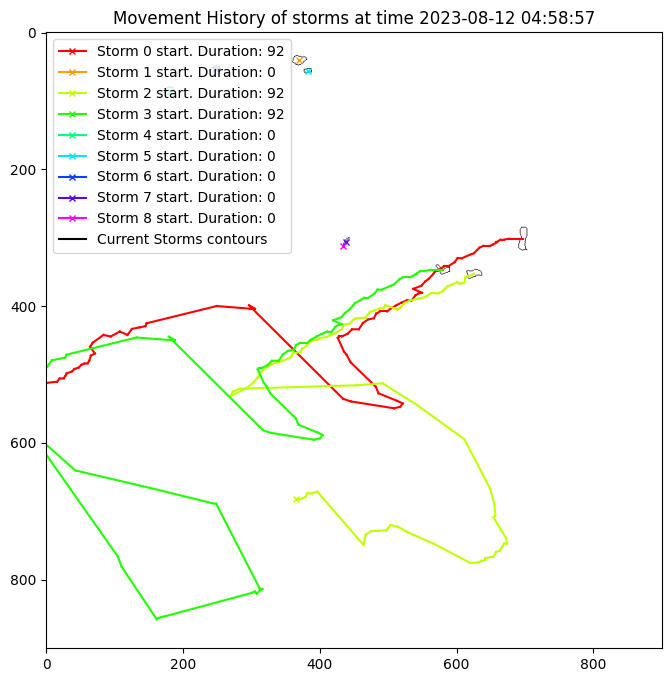

In [18]:
from src.preprocessing import convert_polygons_to_contours

num_maps = len(storms_maps)

model = ISCITPrecipitationModel(identifier=HypothesisIdentifier())  # max_velocity in pixels per hour

for i in tqdm(range(num_maps), desc="Processing all storm maps for movement history visualization"):
    model.processing_map(storms_maps[i])  # Warm-up phase
    # if i == 2:
    #     break

plt.figure(figsize=(8, 8))
blank_img = np.ones(shape=(img_shape[0], img_shape[1], 3), dtype=np.uint8) * 255

current_map = model.storms_maps[-1]
print(f"----  CURRENT MAP at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}  ----")

colors = spectral_colors(len(current_map.storms))

for idx, storm in enumerate(current_map.storms):
    print(f"Storm {idx}: Number of movement history records: {len(storm.history_movements)}")
    current_frame = current_map.time_frame

    color = np.array(colors[idx]) / 255.0
    end_point = (storm.contour.centroid.x, storm.contour.centroid.y)

    # backtrack the movement history
    for move_idx, movement in enumerate(storm.history_movements):
        prev_frame = model.storms_maps[-(move_idx + 2)].time_frame
        dt = (current_frame - prev_frame).total_seconds() / 3600
        current_frame = prev_frame

        dy, dx = movement[0] * dt, movement[1] * dt

        start = end_point[0] - dx, end_point[1] - dy
        plt.plot([start[0], end_point[0]], [start[1], end_point[1]], color=color)
        end_point = start
    
    plt.plot(end_point[0], end_point[1], marker='x', color=color, markersize=5, label=f'Storm {idx} start. Duration: {len(storm.history_movements)}')

contours = convert_polygons_to_contours([storm.contour for storm in current_map.storms])
cv2.drawContours(blank_img, contours, -1, (0, 0, 0), 1)
plt.plot([], [], color='black', label='Current Storms contours')
plt.title(f"Movement History of storms at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")

plt.imshow(blank_img)
plt.legend()

plt.show()